<div class="alert alert-warning">
    
<b>Disclaimer:</b> 
    
The main objective of the <i>Jupyter</i> notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function  
- setting and running the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.  
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.
    
</div>

# Lorentzian + background with lmfit

## Introduction

<div class="alert alert-info">
    
The objective of this notebook is to show how to combine the models of 
the <a href="https://github.com/QENSlibrary/QENSmodels">QENSlibrary</a>. Here, we use the <b>Lorentzian</b> profile and a flat background, created from <b>background_polynomials</b>, to perform some fits.

<a href="https://lmfit.github.io/lmfit-py/">lmfit</a> is used for fitting.
</div>

### Physical units

For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [1]:
# Units of parameters for selected QENS model and experimental data
dict_physical_units = {'omega': "1/ps", 
                       'scale': "unit_of_signal/ps", 
                       'center': "1/ps", 
                       'hwhm': "1/ps",}

## Importing the required librairies

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

# for interactivity (plots, buttons...)
import ipywidgets

from lmfit import Model, Parameters

import QENSmodels

## Plot of the fitting model

The widget below shows the lorentzian peak shape function with a constant background imported from QENSmodels where the functions' parameters *Scale*, *Center*, *FWHM* and *background* can be varied.

In [3]:
# Dictionary of initial values
ini_parameters = {'scale': 5, 'center': 0, 'hwhm': 3, 'background': 0.}

def interactive_fct(scale, center, hwhm, background):
    xs = np.linspace(-10, 10, 100)
    
    fig1, ax1 = plt.subplots()
    ax1.plot(xs, QENSmodels.lorentzian(xs, scale, center, hwhm) +\
             QENSmodels.background_polynomials(xs, background))
    ax1.set_xlabel('x')
    ax1.grid()

# Define sliders for modifiable parameters and their range of variations

scale_slider = ipywidgets.FloatSlider(value=ini_parameters['scale'],
                                      min=0.1, max=10, step=0.1,
                                      description='scale',
                                      continuous_update=False) 

center_slider = ipywidgets.IntSlider(value=ini_parameters['center'],
                                     min=-10, max=10, step=1,
                                     description='center', 
                                     continuous_update=False) 

hwhm_slider = ipywidgets.FloatSlider(value=ini_parameters['hwhm'],
                                     min=0.1, max=10, step=0.1,
                                     description='hwhm',
                                     continuous_update=False)

background_slider = ipywidgets.FloatSlider(value=ini_parameters['background'],
                                       min=0.1, max=10, step=0.1,
                                       description='background',
                                       continuous_update=False)

grid_sliders = ipywidgets.HBox([ipywidgets.VBox([scale_slider, center_slider])
                                ,ipywidgets.VBox([hwhm_slider, background_slider])])
                               
# Define function to reset all parameters' values to the initial ones
def reset_values(b):
    """Reset the interactive plots to inital values."""
    scale_slider.value = ini_parameters['scale'] 
    center_slider.value = ini_parameters['center']  
    hwhm_slider.value = ini_parameters['hwhm'] 
    background_slider.value = ini_parameters['background'] 


# Define reset button and occurring action when clicking on it
reset_button = ipywidgets.Button(description = "Reset")
reset_button.on_click(reset_values)

# Display the interactive plot
interactive_plot = ipywidgets.interactive_output(interactive_fct,       
                                         {'scale': scale_slider,
                                          'center': center_slider,
                                          'hwhm': hwhm_slider,
                                          'background': background_slider})  
                                            
display(grid_sliders, interactive_plot, reset_button)

Output()

Button(description='Reset', style=ButtonStyle())

## Creating the reference data

In [4]:
# Create array of reference data: noisy lorentzian with background
nb_points = 100
xx = np.linspace(-5, 5, nb_points)
added_noise = np.random.normal(0, 1, nb_points)
lorentzian_noisy = QENSmodels.lorentzian(xx, scale=0.89, center=-0.025, hwhm=0.45)*(1 + 0.1*added_noise) +\
                 0.5*( 1. + 0.02*added_noise)

## Setting and fitting

In [5]:
def flat_background(x, A0):
    """ Define flat background ot be added to fitting model"""
    return QENSmodels.background_polynomials(x, A0)

In [6]:
gmodel = Model(QENSmodels.lorentzian) + Model(flat_background)
print('Names of parameters:', gmodel.param_names)
print('Independent variable(s):', gmodel.independent_vars)

initial_parameters_values = [1, 0.2, 0.5, 0.33]

# Fit
result = gmodel.fit(lorentzian_noisy, x=xx, 
                    scale=initial_parameters_values[0], 
                    center=initial_parameters_values[1],
                    hwhm=initial_parameters_values[2],
                    A0=initial_parameters_values[3])

Names of parameters: ['scale', 'center', 'hwhm', 'A0']
Independent variable(s): ['x']


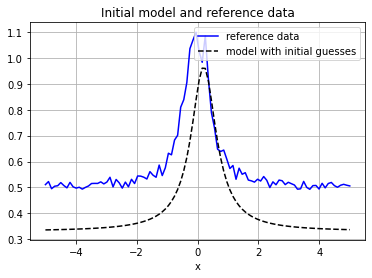

In [7]:
# Plot initial model and reference data
fig0, ax0 = plt.subplots()
ax0.plot(xx, lorentzian_noisy, 'b-', label='reference data')
ax0.plot(xx, result.init_fit, 'k--', label='model with initial guesses')
ax0.set(xlabel='x', title='Initial model and reference data')
ax0.grid()
ax0.legend();

## Plotting results

using methods implemented in `lmfit`

Result of fit:
 [[Model]]
    (Model(lorentzian) + Model(flat_background))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 100
    # variables        = 4
    chi-square         = 0.04851258
    reduced chi-square = 5.0534e-04
    Akaike info crit   = -755.110224
    Bayesian info crit = -744.689544
[[Variables]]
    scale:   0.92298408 +/- 0.02404280 (2.60%) (init = 1)
    center: -0.02403245 +/- 0.00914832 (38.07%) (init = 0.2)
    hwhm:    0.48081062 +/- 0.01521335 (3.16%) (init = 0.5)
    A0:      0.49561147 +/- 0.00307653 (0.62%) (init = 0.33)
[[Correlations]] (unreported correlations are < 0.100)
    C(scale, hwhm) = 0.798
    C(scale, A0)   = -0.682
    C(hwhm, A0)    = -0.524


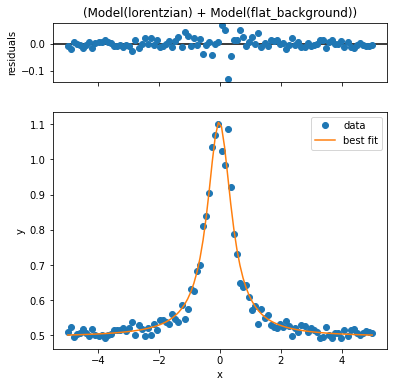

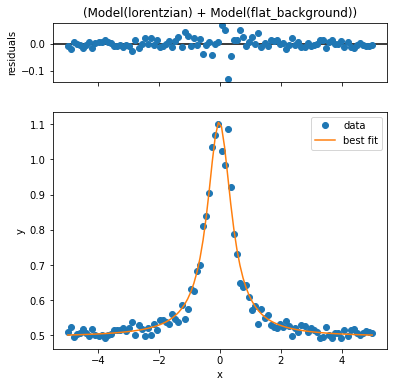

In [8]:
# display result
print('Result of fit:\n', result.fit_report())

# plot fitting result using lmfit functionality
result.plot()

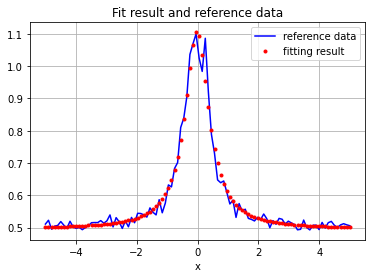

In [9]:
# Plot fitting result and reference data using matplotlib.pyplot
fig1, ax1 = plt.subplots()
ax1.plot(xx, lorentzian_noisy, 'b-', label='reference data')
ax1.plot(xx, result.best_fit, 'r.', label='fitting result')
ax1.legend()
ax1.set(xlabel='x', title='Fit result and reference data')
ax1.grid();

In [10]:
for item in ['hwhm', 'center', 'scale']:
    print(item, result.params[item].value, '+/-', result.params[item].stderr, dict_physical_units[item])

hwhm 0.4808106184962764 +/- 0.015213345245758646 1/ps
center -0.024032454189674146 +/- 0.00914831695130081 1/ps
scale 0.9229840808113892 +/- 0.024042803204474508 unit_of_signal/ps
